<img src="https://raw.githubusercontent.com/Kmilo29/repository/main/images/proyecto.png" ><br>

# MINE-4101: Ciencia de Datos Aplicada
## Universidad de los Andes
Segundo Semestre - 2023


## Empresa OPAIN S.A.


## Integrantes

* Sebastian Arango Loaiza
* Nicolas Adolfo Castillo Betancourt
* Johan David Rodriguez Portela
* Ivan Camilo Delgado Cañon

# Librerias

In [2]:
%load_ext autoreload
%autoreload 2
import pickle

import pandas as pd
import univariate_utils
import multivariate_utils

from exploration import load_datasets
from model_pruning import (
    assign_dataset_configs,
    transform_datasets,
    remove_high_colineality_columns,
    train_base_dataset_models,
    train_best_features_models
)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)
Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


# Constantes

In [11]:
ORIGINAL_METRICS_FILE = "results/summary.csv"
EXTENDED_METRICS_FILE = "extended_data_results/summary.csv"

In [12]:
OUTPUT_MODELS_FILE = "final_models/trained_colineal_models.pkl"

In [13]:
NUM_TRANSFORMS_TO_IGNORE = ["powerTransformer", "polynomialFeatures"]

In [14]:
SELECTION_METRIC = "R2"
LOWER_IS_BEST = False

In [15]:
MAX_COLINEALITY = 0.90

# Utils

In [16]:
def filter_best_models(df: pd.DataFrame) -> pd.DataFrame:
    """Filters best model config by Marca and selected metric in test"""
    df_test = df[
        df["split"] == "test"
    ].sort_values(SELECTION_METRIC, ascending=LOWER_IS_BEST)
    
    df_best = df_test.groupby("dataset").head(1).sort_values("dataset")
    
    return df_best

# Ejecucion

## Lectura de metricas

In [17]:
df_original = pd.read_csv(ORIGINAL_METRICS_FILE)
df_extended = pd.read_csv(EXTENDED_METRICS_FILE)

### Ignorando polynomial features por dificultad de 
Eliminando del análisis las transformaciones polinomiales específicas en los DataFrames, df_original y df_extended, debido a la dificultad en la interpretación de dichas transformaciones. Esto ayuda a simplificar el análisis y a centrarse en características más interpretables y relevantes.

In [18]:
for trans in NUM_TRANSFORMS_TO_IGNORE:
    df_original = df_original[
        df_original["num_config"] != trans
    ].copy(deep=True)
    df_extended = df_extended[
        df_extended["num_config"] != trans
    ].copy(deep=True)    

In [19]:
df_original.head(5)

,split,MSE,MAE,R2,MAPE,dataset,num_config,scat_config,lcat_config,model,columns
0,train,7.877064e+15,6.983090e+07,0.412823,3.408574e+21,marca 1,minMaxScaler,oneHotEncoder__0.0,oneHotEncoder__0.0,linearRegression,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
1,test,8.051213e+15,7.102468e+07,0.401813,2.507123e+21,marca 1,minMaxScaler,oneHotEncoder__0.0,oneHotEncoder__0.0,linearRegression,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
4,train,2.587287e+12,1.230898e+06,0.972818,2.696271e+18,marca 9,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
5,test,3.002276e+13,4.165074e+06,0.681981,8.735012e+18,marca 9,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
8,train,4.459100e+16,1.637745e+08,0.336363,3.077236e+20,muelle,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.05,linearRegression,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."


In [20]:
df_extended.head(5)

,split,MSE,MAE,R2,MAPE,dataset,num_config,scat_config,lcat_config,model,columns
0,train,4.767205e+13,5.057843e+06,0.996447,1.951895e+20,marca 1,robustScaler,oneHotEncoder__0.0,featureHasher__2,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
1,test,1.004725e+15,2.110722e+07,0.923256,1.183147e+21,marca 1,robustScaler,oneHotEncoder__0.0,featureHasher__2,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
2,train,8.044843e+13,7.150972e+06,0.157021,3.885937e+19,marca 9,minMaxScaler,oneHotEncoder__0.05,featureHasher__2,linearRegression,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
3,test,8.092599e+13,7.153825e+06,0.146731,4.708324e+19,marca 9,minMaxScaler,oneHotEncoder__0.05,featureHasher__2,linearRegression,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
4,train,1.260002e+12,8.637393e+05,0.986797,2.730213e+18,marca 9,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."


# Filtrado de mejores resultados en test 
El modelo extendido siempre tiene mejores resultados por marca que el modelo con las features originales. Sin embargo, todos los modelos tienen un numero elevado de features y por ende, necesitan eliminacion de features para mayor interpretabilidad.

In [21]:
df_original_best = filter_best_models(df_original)
df_original_best

,split,MSE,MAE,R2,MAPE,dataset,num_config,scat_config,lcat_config,model,columns
441,test,1.596505e+15,2.778621e+07,0.881383,6.257433e+20,marca 1,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
917,test,2.944826e+13,3.625213e+06,0.655584,5.061418e-01,marca 10,robustScaler,oneHotEncoder__0.05,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
869,test,2.787228e+14,1.254967e+07,0.775797,3.918242e-01,marca 2,minMaxScaler,oneHotEncoder__0.0,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
429,test,9.084574e+14,2.256251e+07,0.756032,3.491769e-01,marca 3,robustScaler,oneHotEncoder__0.0,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
595,test,2.028898e+14,1.000055e+07,0.655563,1.567375e+00,marca 5,robustScaler,oneHotEncoder__0.05,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
87,test,4.860306e+14,1.539156e+07,0.663141,3.270523e+19,marca 6,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
139,test,2.888428e+13,3.891792e+06,0.593538,1.802702e+21,marca 7,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
227,test,3.002276e+13,4.165074e+06,0.681981,8.735012e+18,marca 9,standardScaler,oneHotEncoder__0.05,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
801,test,6.881388e+15,5.836895e+07,0.895409,2.075118e+19,muelle,robustScaler,oneHotEncoder__0.05,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."


In [22]:
df_extended_best = filter_best_models(df_extended)
df_extended_best

,split,MSE,MAE,R2,MAPE,dataset,num_config,scat_config,lcat_config,model,columns
265,test,9.315888e+14,2.054666e+07,0.928842,1.153843e+21,marca 1,standardScaler,oneHotEncoder__0.0,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
161,test,2.684137e+13,3.412393e+06,0.684748,4.795939e-01,marca 10,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
963,test,2.199509e+14,1.107418e+07,0.825614,3.703004e-01,marca 2,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
657,test,7.050922e+14,1.975757e+07,0.804904,2.971616e-01,marca 3,minMaxScaler,oneHotEncoder__0.05,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
183,test,1.963122e+14,9.879837e+06,0.650056,1.516551e+00,marca 5,robustScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
613,test,4.209651e+14,1.457378e+07,0.702632,2.998583e+19,marca 6,standardScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
1001,test,2.584761e+13,3.822018e+06,0.625202,1.716043e+21,marca 7,robustScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
631,test,2.150488e+13,3.502161e+06,0.773256,3.853363e+18,marca 9,robustScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."
799,test,4.499722e+15,4.654834e+07,0.934495,3.489620e+19,muelle,robustScaler,oneHotEncoder__0.05,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'..."


In [23]:
df_original_best["feature_set"] = "original"
df_extended_best["feature_set"] = "extended"

df_best_configs = filter_best_models(
    pd.concat([df_original_best, df_extended_best])
)

In [24]:
df_best_configs["feature_count"] = df_best_configs["columns"].apply(
    lambda x: len(eval(x))
)

In [25]:
df_best_configs

,split,MSE,MAE,R2,MAPE,dataset,num_config,scat_config,lcat_config,model,columns,feature_set,feature_count
265,test,9.315888e+14,2.054666e+07,0.928842,1.153843e+21,marca 1,standardScaler,oneHotEncoder__0.0,oneHotEncoder__0.05,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,175
161,test,2.684137e+13,3.412393e+06,0.684748,4.795939e-01,marca 10,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
963,test,2.199509e+14,1.107418e+07,0.825614,3.703004e-01,marca 2,minMaxScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
657,test,7.050922e+14,1.975757e+07,0.804904,2.971616e-01,marca 3,minMaxScaler,oneHotEncoder__0.05,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
595,test,2.028898e+14,1.000055e+07,0.655563,1.567375e+00,marca 5,robustScaler,oneHotEncoder__0.05,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",original,20
613,test,4.209651e+14,1.457378e+07,0.702632,2.998583e+19,marca 6,standardScaler,oneHotEncoder__0.0,featureHasher__10,randomForest,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
1001,test,2.584761e+13,3.822018e+06,0.625202,1.716043e+21,marca 7,robustScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
631,test,2.150488e+13,3.502161e+06,0.773256,3.853363e+18,marca 9,robustScaler,oneHotEncoder__0.0,featureHasher__10,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,35
799,test,4.499722e+15,4.654834e+07,0.934495,3.489620e+19,muelle,robustScaler,oneHotEncoder__0.05,oneHotEncoder__0.0,lgbmregressor,"['Hora entera', 'Pasajeros saliendo', 'Semana'...",extended,174


# Visualizando que influencia mas las metricas en test
Visualizando y verificando la influencia de varias variables en las métricas de un conjunto de prueba. Inicialmente, se filtran los datos del DataFrame df_extended para seleccionar solo las métricas correspondientes al conjunto de prueba. Luego, se realizan transformaciones en dos columnas para simplificar su visualización. Después, el código itera a través de varias columnas, como "dataset", "num_config", "scat_config", "lcat_config" y "model", y muestra gráficos y análisis para cada una de ellas. Estas visualizaciones ayudan a comprender cómo cada variable afecta una métrica específica definida por SELECTION_METRIC en el conjunto de prueba.

In [26]:
df_plot_metrics = df_extended[
    df_extended["split"] == "test"
].copy(deep=True)

In [17]:
df_plot_metrics["scat_config_type"] =  df_plot_metrics["scat_config"].apply(
    lambda x: x.split("__")[0]
)
df_plot_metrics["lcat_config_type"] =  df_plot_metrics["lcat_config"].apply(
    lambda x: x.split("__")[0]
)

****************************************************************************************************
dataset influence over R2


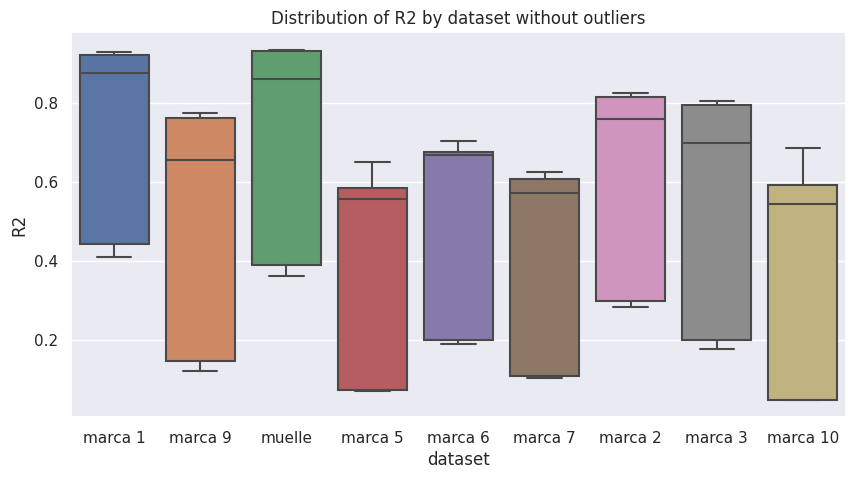

dataset,marca 1,marca 10,marca 2,marca 3,marca 5,marca 6,marca 7,marca 9,muelle
count,4.500000e+01,4.500000e+01,4.500000e+01,4.500000e+01,4.500000e+01,4.500000e+01,45.000000,4.500000e+01,4.500000e+01
mean,-2.278269e+51,-1.769792e+34,-4.921758e+27,-7.516343e+22,-3.718664e+49,-9.778328e+49,-1771.353232,-3.001521e+51,-1.492856e+26
std,1.057593e+52,4.563125e+34,2.250133e+28,1.792620e+23,1.132252e+50,3.243279e+50,5584.260910,7.669968e+51,4.140727e+26
min,-5.076801e+52,-1.336028e+35,-1.080236e+29,-5.909573e+23,-5.649020e+50,-1.525718e+51,-19442.283503,-2.987986e+52,-1.704726e+27
5%,-2.483399e+50,-1.322995e+35,-4.345534e+27,-4.644139e+23,-2.771242e+50,-4.023716e+50,-19442.283503,-2.215878e+52,-1.183406e+27
25%,4.430007e-01,4.808631e-02,2.976062e-01,2.004873e-01,7.256577e-02,1.983512e-01,0.107710,1.467312e-01,3.885274e-01
50%,8.758682e-01,5.440275e-01,7.587521e-01,6.976921e-01,5.564752e-01,6.668912e-01,0.572007,6.553998e-01,8.610497e-01
75%,9.221477e-01,5.929755e-01,8.138673e-01,7.952938e-01,5.851467e-01,6.762245e-01,0.606528,7.628247e-01,9.305899e-01
95%,9.288422e-01,6.824998e-01,8.222683e-01,8.035669e-01,6.482004e-01,6.998785e-01,0.618549,7.712337e-01,9.344457e-01
max,9.288422e-01,6.847477e-01,8.256143e-01,8.049036e-01,6.500562e-01,7.026315e-01,0.625202,7.732564e-01,9.344953e-01


****************************************************************************************************
num_config influence over R2


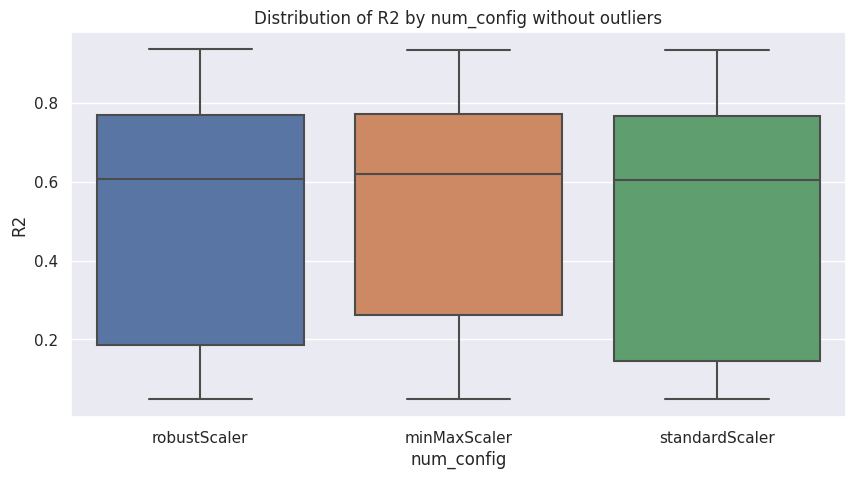

num_config,minMaxScaler,robustScaler,standardScaler
count,1.080000e+02,1.080000e+02,1.890000e+02
mean,-2.884881e+50,-1.121675e+51,-4.834209e+50
std,2.874975e+51,6.944752e+51,3.196173e+51
min,-2.987986e+52,-5.076801e+52,-2.215878e+52
5%,-4.127401e+27,-9.917167e+50,-2.255592e+50
25%,2.623459e-01,1.859891e-01,1.467312e-01
50%,6.185491e-01,6.065282e-01,6.042683e-01
75%,7.713602e-01,7.680502e-01,7.666360e-01
95%,9.237159e-01,9.260458e-01,9.288422e-01
max,9.341692e-01,9.344953e-01,9.344457e-01


****************************************************************************************************
scat_config influence over R2


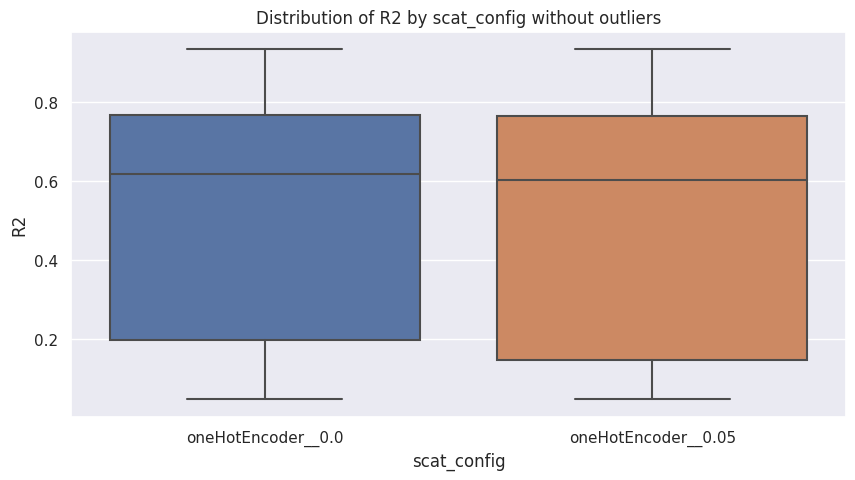

scat_config,oneHotEncoder__0.0,oneHotEncoder__0.05
count,2.160000e+02,1.890000e+02
mean,-4.919154e+50,-7.270394e+50
std,4.079614e+51,4.851002e+51
min,-5.076801e+52,-5.076801e+52
5%,-4.504424e+49,-2.724268e+50
25%,1.983512e-01,1.467312e-01
50%,6.178974e-01,6.042683e-01
75%,7.687195e-01,7.666360e-01
95%,9.247610e-01,9.282237e-01
max,9.344953e-01,9.344953e-01


****************************************************************************************************
lcat_config influence over R2


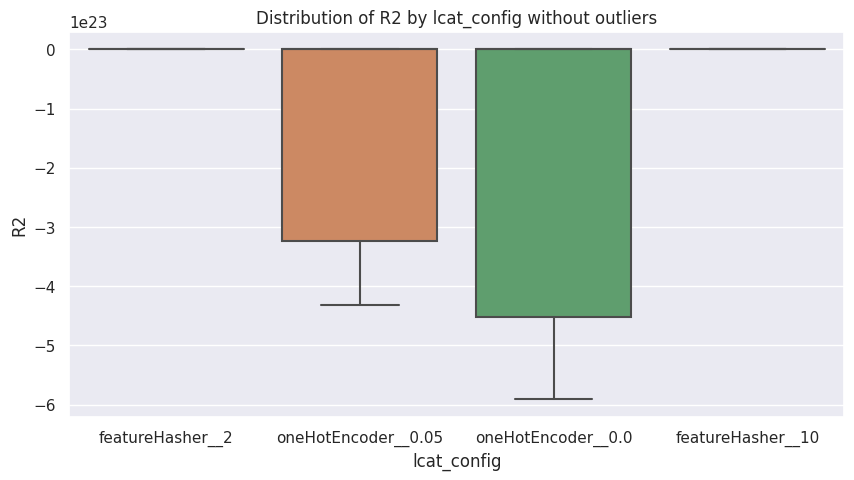

lcat_config,featureHasher__10,featureHasher__2,oneHotEncoder__0.0,oneHotEncoder__0.05
count,108.000000,108.000000,1.350000e+02,5.400000e+01
mean,0.557056,0.550806,-1.466525e+51,-8.459867e+50
std,0.281019,0.271603,7.166381e+51,4.219666e+51
min,0.048063,0.048086,-5.076801e+52,-2.215878e+52
5%,0.069407,0.072566,-3.551020e+51,-2.771242e+50
25%,0.282965,0.297606,-4.522509e+23,-3.239845e+23
50%,0.648744,0.607133,5.984120e-01,5.929755e-01
75%,0.780628,0.759799,7.666360e-01,7.627922e-01
95%,0.921503,0.923832,9.287245e-01,9.288422e-01
max,0.931156,0.931030,9.344953e-01,9.344457e-01


****************************************************************************************************
model influence over R2


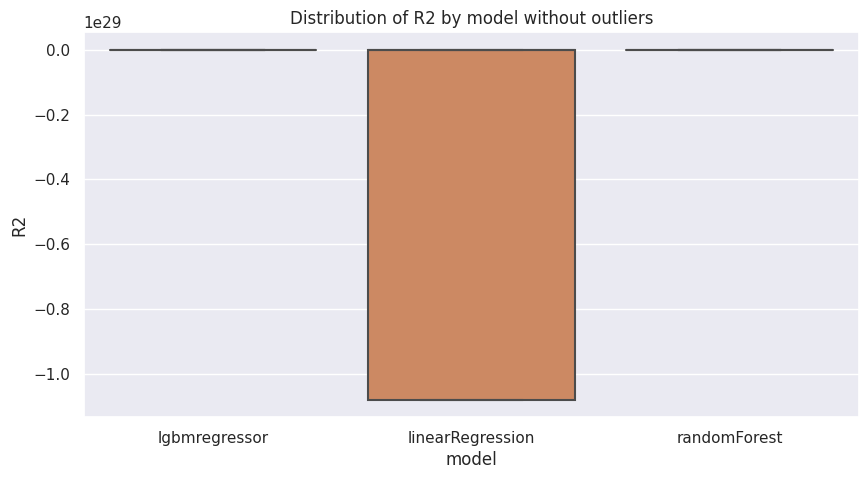

model,lgbmregressor,linearRegression,randomForest
count,135.000000,1.350000e+02,135.000000
mean,0.738027,-1.804920e+51,0.704700
std,0.137948,7.587663e+51,0.105675
min,0.538640,-5.076801e+52,0.549365
5%,0.544027,-1.244134e+52,0.555203
25%,0.604268,-1.080236e+29,0.645110
50%,0.766636,4.808631e-02,0.684748
75%,0.820325,1.891914e-01,0.770332
95%,0.932060,4.102988e-01,0.878023
max,0.934495,4.430007e-01,0.883480


In [18]:
for col in ["dataset", "num_config", "scat_config", "lcat_config", "model"]:
    print("*" * 100)
    print(f"{col} influence over {SELECTION_METRIC}")
    multivariate_utils.plot_distributions(
        df_plot_metrics,
        SELECTION_METRIC,
        col,
        (10, 5),
        "box",  # Puede ser hist o box
        False
    )
    multivariate_utils.make_column_non_graphic_analysis(
        df_plot_metrics,
        SELECTION_METRIC,
        col
    )

# Transformacion de datasets

In [19]:
datasets = assign_dataset_configs(df_best_configs)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 33.96it/s]


In [20]:
datasets["muelle"].keys()

dict_keys(['X_train', 'X_test', 'y_train', 'y_test', 'config'])

In [21]:
for marca in datasets:
    print(marca)
    print(datasets[marca]["config"])

muelle
{'num_config': 'robustScaler', 'scat_config': ['oneHotEncoder', '0.05'], 'lcat_config': ['oneHotEncoder', '0.0'], 'model': 'lgbmregressor'}
marca 1
{'num_config': 'standardScaler', 'scat_config': ['oneHotEncoder', '0.0'], 'lcat_config': ['oneHotEncoder', '0.05'], 'model': 'lgbmregressor'}
marca 2
{'num_config': 'minMaxScaler', 'scat_config': ['oneHotEncoder', '0.0'], 'lcat_config': ['featureHasher', '10'], 'model': 'lgbmregressor'}
marca 3
{'num_config': 'minMaxScaler', 'scat_config': ['oneHotEncoder', '0.05'], 'lcat_config': ['featureHasher', '10'], 'model': 'lgbmregressor'}
marca 5
{'num_config': 'robustScaler', 'scat_config': ['oneHotEncoder', '0.05'], 'lcat_config': ['featureHasher', '10'], 'model': 'randomForest'}
marca 6
{'num_config': 'standardScaler', 'scat_config': ['oneHotEncoder', '0.0'], 'lcat_config': ['featureHasher', '10'], 'model': 'randomForest'}
marca 7
{'num_config': 'robustScaler', 'scat_config': ['oneHotEncoder', '0.0'], 'lcat_config': ['featureHasher', '10'

In [22]:
datasets_trans = transform_datasets(datasets)

  0%|                                                     | 0/9 [00:00<?, ?it/s]/home/johan/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/home/johan/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
 11%|█████                                        | 1/9 [00:00<00:02,  3.87it/s]/home/johan/miniconda3/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:972: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.

In [23]:
(
    datasets_trans["muelle"]["X_train"].shape,
    datasets_trans["muelle"]["X_test"].shape,
    len(datasets_trans["muelle"]["columns"])
)

((40267, 174), (10067, 174), 174)

# Eliminacion de columnas con alta colinealidad

In [24]:
#remove_high_colineality_columns(datasets_trans, MAX_COLINEALITY)

In [25]:
for marca, marca_config in datasets_trans.items():
    print(f"Marca {marca} now has {len(marca_config['columns'])} features")

Marca muelle now has 174 features
Marca marca 1 now has 175 features
Marca marca 2 now has 35 features
Marca marca 3 now has 35 features
Marca marca 5 now has 35 features
Marca marca 6 now has 35 features
Marca marca 7 now has 35 features
Marca marca 9 now has 35 features
Marca marca 10 now has 35 features


# Entrenamiento de modelos para hallar features mas relevantes
Como se usan modelos no lineales, se necesita entender la linealidad de las features con la variable de salida por medio de la importancia de las features.

In [26]:
datasets_trans["muelle"]["config"]

{'num_config': 'robustScaler',
 'scat_config': ['oneHotEncoder', '0.05'],
 'lcat_config': ['oneHotEncoder', '0.0'],
 'model': 'lgbmregressor'}

In [27]:
train_base_dataset_models(datasets_trans)

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  37.7s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  39.2s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  34.5s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  15.9s
[CV] END

 11%|████▌                                    | 1/9 [41:25<5:31:24, 2485.53s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  26.1s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  32.2s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  33.4s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  12.1s
[CV] END

 22%|████████▋                              | 2/9 [1:20:41<4:41:04, 2409.22s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  32.4s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  32.0s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  35.9s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  14.8s
[CV] END

 33%|█████████████                          | 3/9 [1:59:40<3:57:43, 2377.20s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  31.5s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  29.3s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  30.1s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  14.3s
[CV] END

 44%|█████████████████▎                     | 4/9 [2:34:22<3:08:23, 2260.61s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   7.9s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   7.4s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   7.7s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.0s
[CV] END bootstrap=True, max_depth=40, max_featu

 56%|█████████████████████▋                 | 5/9 [2:39:37<1:43:56, 1559.23s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   8.5s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   8.3s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   8.4s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=40, max_featu

 67%|███████████████████████████▎             | 6/9 [2:45:34<57:31, 1150.42s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  29.6s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  32.9s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  28.3s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  13.7s
[CV] END

 78%|███████████████████████████████▉         | 7/9 [3:21:34<49:21, 1480.53s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  29.6s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  31.0s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  33.7s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  14.4s
[CV] END

 89%|████████████████████████████████████▍    | 8/9 [3:59:12<28:47, 1727.74s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   3.6s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   3.2s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   3.0s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.6s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.5s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.6s
[CV] END bootstrap=True, max_depth=40, max_featu

100%|█████████████████████████████████████████| 9/9 [4:01:43<00:00, 1611.46s/it]


In [28]:
datasets_trans["muelle"]["metrics"]

,split,MSE,MAE,R2,MAPE,marca
0,train,1.326739e+15,2.735156e+07,0.979924,2.109876e+19,muelle
0,test,4.806229e+15,4.947991e+07,0.930033,3.694157e+19,muelle


In [29]:
df_no_colineal_metrics = pd.concat(
    [
        marca_config["metrics"]
        for marca, marca_config in datasets_trans.items()
    ]
)
df_no_colineal_metrics

,split,MSE,MAE,R2,MAPE,marca
0,train,1.326739e+15,2.735156e+07,0.979924,2.109876e+19,muelle
0,test,4.806229e+15,4.947991e+07,0.930033,3.694157e+19,muelle
0,train,2.384127e+14,1.140381e+07,0.982229,4.349752e+20,marca 1
0,test,9.897215e+14,2.156939e+07,0.924402,1.343960e+21,marca 1
0,train,1.180615e+13,2.588322e+06,0.990508,9.300294e-02,marca 2
0,test,2.035371e+14,1.042256e+07,0.838628,3.425386e-01,marca 2
0,train,3.549163e+13,4.443849e+06,0.990435,7.747138e-02,marca 3
0,test,6.522378e+14,1.864336e+07,0.819528,2.806679e-01,marca 3
0,train,1.338905e+13,2.305064e+06,0.977294,3.248116e-01,marca 5
0,test,1.886622e+14,9.643886e+06,0.663693,1.481254e+00,marca 5


In [30]:
df_no_colineal_metrics[
    df_no_colineal_metrics["split"] == "test"
].sort_values("marca")

,split,MSE,MAE,R2,MAPE,marca
0,test,9.897215e+14,2.156939e+07,0.924402,1.343960e+21,marca 1
0,test,2.531027e+13,3.302821e+06,0.702731,4.665938e-01,marca 10
0,test,2.035371e+14,1.042256e+07,0.838628,3.425386e-01,marca 2
0,test,6.522378e+14,1.864336e+07,0.819528,2.806679e-01,marca 3
0,test,1.886622e+14,9.643886e+06,0.663693,1.481254e+00,marca 5
0,test,4.080909e+14,1.426159e+07,0.711726,2.820804e+19,marca 6
0,test,2.360765e+13,3.603842e+06,0.657682,1.603572e+21,marca 7
0,test,1.996236e+13,3.308265e+06,0.789520,6.585275e+18,marca 9
0,test,4.806229e+15,4.947991e+07,0.930033,3.694157e+19,muelle


# Entrenamiento de modelos con features que altos coeficientes

In [31]:
MARCA_TOP_FEATURES = {
    marca: 20
    for marca in datasets_trans
}

In [32]:
top_features_datasets_trans = train_best_features_models(datasets_trans, MARCA_TOP_FEATURES)

100%|█████████████████████████████████████████████| 9/9 [00:00<00:00, 10.30it/s]


In [33]:
train_base_dataset_models(top_features_datasets_trans)

  0%|                                                     | 0/9 [00:00<?, ?it/s]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  23.8s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  23.4s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  25.0s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  10.8s
[CV] END

 11%|████▌                                    | 1/9 [33:12<4:25:39, 1992.49s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  22.1s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  22.0s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  22.0s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=   9.7s
[CV] END

 22%|████████▋                              | 2/9 [1:03:48<3:41:41, 1900.26s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  20.8s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  20.3s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  22.4s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=   9.0s
[CV] END

 33%|█████████████                          | 3/9 [1:33:24<3:04:22, 1843.72s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  23.3s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  23.0s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  29.4s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=   9.4s
[CV] END

 44%|█████████████████▎                     | 4/9 [2:03:47<2:32:56, 1835.35s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   5.5s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   5.2s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   5.4s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.0s
[CV] END bootstrap=True, max_depth=40, max_featu

 56%|█████████████████████▋                 | 5/9 [2:08:13<1:24:38, 1269.53s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   6.5s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   6.0s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   6.5s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.1s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=40, max_featu

 67%|████████████████████████████              | 6/9 [2:13:15<47:01, 940.66s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  32.9s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  24.4s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  22.6s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=  11.2s
[CV] END

 78%|████████████████████████████████▋         | 7/9 [2:24:16<28:18, 849.16s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=   1.2s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=   1.2s
[CV] END boosting_type=gbdt, learning_rate=0.9051711412067741, max_depth=32, metric=rmse, min_data=30, n_estimators=288, n_jobs=-1, num_leaves=231, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=   1.2s
[CV] END boosting_type=gbdt, learning_rate=0.3961810897465745, max_depth=27, metric=rmse, min_data=30, n_estimators=555, n_jobs=-1, num_leaves=50, objective=regression, sub_feature=0.5466954666408405, verbose=-1; total time=   0.6s
[CV] END

 89%|█████████████████████████████████████▎    | 8/9 [2:27:10<10:34, 634.13s/it]

Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   1.3s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=False, max_depth=50, max_features=None, min_samples_leaf=1, min_samples_split=10, n_estimators=555, n_jobs=-1; total time=   1.2s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.3s
[CV] END bootstrap=True, max_depth=30, max_features=log2, min_samples_leaf=2, min_samples_split=10, n_estimators=200, n_jobs=-1; total time=   0.3s
[CV] END bootstrap=True, max_depth=40, max_featu

100%|██████████████████████████████████████████| 9/9 [2:28:14<00:00, 988.28s/it]


In [34]:
for marca, marca_config in top_features_datasets_trans.items():
    print(f"Marca {marca} now has {len(marca_config['columns'])} features")

Marca muelle now has 20 features
Marca marca 1 now has 20 features
Marca marca 2 now has 20 features
Marca marca 3 now has 20 features
Marca marca 5 now has 20 features
Marca marca 6 now has 20 features
Marca marca 7 now has 20 features
Marca marca 9 now has 20 features
Marca marca 10 now has 20 features


In [35]:
df_top_feat_metrics = pd.concat(
    [
        marca_config["metrics"]
        for marca, marca_config in top_features_datasets_trans.items()
    ]
)
df_top_feat_metrics

,split,MSE,MAE,R2,MAPE,marca
0,train,6.881281e+14,1.805253e+07,0.989587,1.012747e+19,muelle
0,test,7.606608e+15,5.858545e+07,0.889267,4.240401e+19,muelle
0,train,1.317599e+14,7.761707e+06,0.990179,3.229022e+20,marca 1
0,test,1.427340e+15,2.524470e+07,0.890975,1.556742e+21,marca 1
0,train,1.355072e+13,2.757355e+06,0.989105,9.649320e-02,marca 2
0,test,2.084124e+14,1.053257e+07,0.834762,3.541279e-01,marca 2
0,train,5.948067e+13,5.641636e+06,0.983970,9.905455e-02,marca 3
0,test,8.431004e+14,2.149545e+07,0.766717,3.294975e-01,marca 3
0,train,1.471667e+13,2.156110e+06,0.975042,2.926259e-01,marca 5
0,test,1.677988e+14,8.441566e+06,0.700884,1.258193e+00,marca 5


In [36]:
df_top_feat_metrics[
    df_top_feat_metrics["split"] == "test"
].sort_values("marca")

,split,MSE,MAE,R2,MAPE,marca
0,test,1.427340e+15,2.524470e+07,0.890975,1.556742e+21,marca 1
0,test,2.173302e+13,2.763049e+06,0.744745,3.763606e-01,marca 10
0,test,2.084124e+14,1.053257e+07,0.834762,3.541279e-01,marca 2
0,test,8.431004e+14,2.149545e+07,0.766717,3.294975e-01,marca 3
0,test,1.677988e+14,8.441566e+06,0.700884,1.258193e+00,marca 5
0,test,3.810338e+14,1.293121e+07,0.730839,2.390756e+19,marca 6
0,test,2.695299e+13,3.871275e+06,0.609173,1.717809e+21,marca 7
0,test,2.038792e+13,3.346159e+06,0.785033,5.097669e+18,marca 9
0,test,7.606608e+15,5.858545e+07,0.889267,4.240401e+19,muelle


In [37]:
for marca, marca_config in top_features_datasets_trans.items():
    print("*" * 20)
    print(f"Marca {marca} columns: {marca_config['columns']}")

********************
Marca muelle columns: ['Día', 'Hora entera', 'Semana', 'Minuto entero', 'Pasajeros saliendo', 'sin_Hora entera', 'sin_Día', 'cos_Semana', 'cos_Día', 'sin_Semana', 'cos_Hora entera', 'Mes', 'Hdi2021', 'sin_Mes', 'cos_Mes', 'avianca s a', 'domingo', 'lunes', 'North America', 'sabado']
********************
Marca marca 1 columns: ['Minuto entero', 'Pasajeros saliendo', 'Hora entera', 'Semana', 'sin_Día', 'Día', 'sin_Hora entera', 'cos_Semana', 'sin_Semana', 'cos_Hora entera', 'cos_Día', 'Hdi2021', 'Mes', 'cos_Mes', 'avianca s a', 'sin_Mes', 'North America', 'latam airlines', 'legacy', 'domingo']
********************
Marca marca 2 columns: ['Pasajeros saliendo', 'Día', 'sin_Día', 'Semana', 'Hora entera', 'cos_Día', 'Minuto entero', 'sin_Semana', 'cos_Semana', 'sin_Hora entera', 'Hdi2021', 'cos_Hora entera', 'Sala__0', 'Mes', 'sabado', 'viernes', 'jueves', 'domingo', 'martes', 'lunes']
********************
Marca marca 3 columns: ['Pasajeros saliendo', 'Día', 'sin_Día', '

In [42]:
with open(OUTPUT_MODELS_FILE, "wb") as f:
    pickle.dump(top_features_datasets_trans, f)